# Modifications to Code Output from LLM following Iteration 15

Following the series of errors by the LLM to implement the changes in iterations 13, 14 and 15, it was decided to write the remaining model logic manually. As more code is changed than that output by the LLM, it becomes increasingly difficult for it to understand the context of the model and thus be able to implement the changes required. It is not possible to pass the full model code to the LLM due to character restrictions.

**Aim**

To implement the change attempted by the LLM in iteration 15.

Changes:
- Change length of stay for Stroke patients depending if they go to ESD or if they are a mortality case

**Edited Code**

In [1]:
import simpy
import numpy as np
import math
import pandas as pd
import itertools
import random
import matplotlib.pyplot as plt

In [2]:
# Beds in stroke ward
NUM_BEDS = 10
# Patient types that can arrive
PATIENTS = ['Stroke', 'TIA', 'Complex NL', 'Other']

# Interarrival times for patients
STROKE_IAT = 1.2
TIA_IAT = 9.3
CNL_IAT = 3.6
OTHER_IAT = 3.2

##### MODIFICATION - mortality cases #####
# Mortality of patient probability
STROKE_MORT_PROB = 0.02

# Length of stay parameters for patients (mean and stdev)
STROKE_LOS = (7.4, 8.6)
STROKE_ESD_LOS = (4.6, 4.8)
STROKE_MORT_LOS = (7.0, 8.7)
TIA_LOS = (1.8, 2.3)
CNL_LOS = (4.0, 5.0)
OTHER_LOS = (3.8, 5.2)

# Probability of where patient go after stroke ward (ESD, rehab unit, other)
STROKE_PROB = [0.13, 0.24, 0.63]
CNL_PROB = [0.05, 0.11, 0.84]
TIA_PROB = [0.01, 0.01, 0.98]
OTHER_PROB = [0.10, 0.05, 0.85]

TRACE = True

# Default random number set
#DEFAULT_RNG_SET = None
DEFAULT_RNG_SET = [45, 10, 20, 30, 40, 50, 60, 70, 80, 90]
N_STREAMS = 10

# Default results collection period
DEFAULT_RESULTS_COLLECTION_PERIOD = 60

# Default number of replications
DEFAULT_N_REPS = 10

In [3]:
def trace(msg):
    '''
    Utility function for printing simulation.
    Set the TRACE constant to FALSE to turn tracing off.
    
    Params:
    -------
    msg: str
        string to print to screen.
    '''
    if TRACE:
        print(msg)

In [4]:
class Exponential:
    '''
    Convenience class for the exponential distribution.
    '''
    def __init__(self, mean, random_seed=None):
        '''
        Constructor
        
        Parameters:
        ------------
        mean: float
            Mean of the exponential distribution.
        
        random_seed: int, optional (default=None)
            A random seed to reproduce samples.
            If set to none then a unique sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.mean = mean
        
    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution.
        
        Parameters:
        -----------
        size: int, optional (default=None)
            Number of samples to return.
            If size=None then a single sample is returned.
        '''
        return self.rand.exponential(self.mean, size=size)


class Lognormal:
    '''
    Convenience class for the lognormal distirbution.
    '''
    def __init__(self, params, random_seed=None):
        '''
        Parameters:
        -----------
        params: mean, stdev (float, float)
            Mean = mean of the lognormal distribution
            Stdev = standard dev of the lognormal distribution
        '''
        mean = params[0]
        stdev = params[1]
        self.rand = np.random.default_rng(seed=random_seed)
        mu, sigma = self.normal_moments_from_lognormal(mean, stdev**2)
        self.mu = mu
        self.sigma = sigma
        
    def normal_moments_from_lognormal(self, m, v):
        '''
        Returns mu and sigma of normal distribution
        underlying a lognormal with mean m and variance v

        Parameters:
        ------------
        m: float
            Mean of lognormal distribution
        v: float
            Variance of lognormal distribution
                
        Returns:
        -------
        mu, sigma: (float, float)
        '''
        phi = math.sqrt(v + m**2)
        mu = math.log(m**2/phi)
        sigma = math.sqrt(math.log(phi**2/m**2))
        return mu, sigma
        
    def sample(self):
        '''
        Sample from the normal distribution
        '''
        return self.rand.lognormal(self.mu, self.sigma)

class Bernoulli:
    '''
    Convenience class for the Bernoulli distribution.
    '''
    def __init__(self, p, random_seed=None):
        '''
        Constructor

        Parameters:
        ------------
        p: float
            Probability of drawing a 1.

        random_seed: int, optional (default=None)
            A random seed to reproduce samples.
            If set to none then a unique sample is created.
        '''
        self.rand = np.random.default_rng(seed=random_seed)
        self.p = p

    def sample(self, size=None):
        '''
        Generate a sample from the exponential distribution.

        Parameters:
        ------------
        size: int, optional (default=None)
            Number of samples to return.
            If size=None then a single sample is returned.
        '''
        return self.rand.binomial(n=1, p=self.p, size=size)

In [5]:
class Scenario:
    '''
    Parameter class for stroke ward simulation model.
    '''
    def __init__(self, random_number_set=DEFAULT_RNG_SET):
        
        self.num_beds = NUM_BEDS
        self.warm_up = 0.0

        # Sampling
        self.random_number_set = random_number_set
        self.init_sampling()
    
    def set_random_no_set(self, random_number_set):
        '''
        Controls the random sampling.

        Parameters:
        ----------
        random_number_set: int
            Used to control the set of psuedo random numbers
            used by the distributions in the simulation.
        '''
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        '''
        Create the distributions used by the model and initialise 
        the random seeds of each.
        '''
        # create random number streams
        rng_streams = np.random.default_rng(self.random_number_set)
        self.seeds = rng_streams.integers(0, 999999999, size=N_STREAMS)

        # Create distributions for arrival times
        self.stroke_arrival_dist = Exponential(STROKE_IAT,
                                               random_seed=self.seeds[0])
        self.tia_arrival_dist = Exponential(TIA_IAT,
                                            random_seed=self.seeds[1])
        self.cnl_arrival_dist = Exponential(CNL_IAT,
                                            random_seed=self.seeds[2])
        self.other_arrival_dist = Exponential(OTHER_IAT,
                                              random_seed=self.seeds[3])

        ##### MODIFICATION - LOS depends on ESD or mortality case #####
        # Creates distributions for length of stay
        self.stroke_los_dist = Lognormal(STROKE_LOS, random_seed=self.seeds[0])
        self.stroke_esd_los_dist = Lognormal(STROKE_ESD_LOS,
                                             random_seed=self.seeds[0])
        self.stroke_mort_los_dist = Lognormal(STROKE_MORT_LOS,
                                              random_seed=self.seeds[0])
        self.tia_los_dist = Lognormal(TIA_LOS, random_seed=self.seeds[1])
        self.cnl_los_dist = Lognormal(CNL_LOS, random_seed=self.seeds[2])
        self.other_los_dist = Lognormal(OTHER_LOS, random_seed=self.seeds[3])

        ##### MODIFICATION - possibility of mortality #####
        # Probability of mortality
        self.p_stroke_mort = Bernoulli(STROKE_MORT_PROB,
                                       random_seed=self.seeds[0])

        # Creates distributions for whether a patient goes to ESD using prob
        self.p_stroke_to_esd = Bernoulli(STROKE_PROB[0],
                                         random_seed=self.seeds[0])
        self.p_tia_to_esd = Bernoulli(TIA_PROB[0], random_seed=self.seeds[1])
        self.p_cnl_to_esd = Bernoulli(CNL_PROB[0], random_seed=self.seeds[2])
        self.p_other_to_esd = Bernoulli(OTHER_PROB[0],
                                        random_seed=self.seeds[3])

        # Calculates probability that go to rehab, given that they did not go
        # to ESD - e.g. 0.24 / 0.87 (probability they did not go to ESD)
        STROKE_PROB_REHAB = STROKE_PROB[1] / (1 - STROKE_PROB[0])
        TIA_PROB_REHAB = TIA_PROB[1] / (1 - TIA_PROB[0])
        CNL_PROB_REHAB = CNL_PROB[1] / (1 - CNL_PROB[0])
        OTHER_PROB_REHAB = OTHER_PROB[1] / (1 - OTHER_PROB[0])

        # Creates distributions for whether a patient goes to rehab given
        # they did not go to ESD
        self.p_stroke_to_rehab = Bernoulli(STROKE_PROB_REHAB,
                                           random_seed=self.seeds[0])
        self.p_tia_to_rehab = Bernoulli(TIA_PROB_REHAB,
                                        random_seed=self.seeds[1])
        self.p_cnl_to_rehab = Bernoulli(CNL_PROB_REHAB,
                                        random_seed=self.seeds[2])
        self.p_other_to_rehab = Bernoulli(OTHER_PROB_REHAB,
                                          random_seed=self.seeds[3])

In [6]:
class StrokeWard:
    '''
    Model of a stroke ward.
    Patients of type Stroke, Transient Ischemic Attack (IAT), Complex
    Neurological or Other enter a stroke ward and stay for a length of time.
    Then they leave the model to one of three locations:
    Early Supported Discharge (ESD), Rehab Unit or Other.
    '''
    def __init__(self, scenario):
        self.env = simpy.Environment()
        self.beds = simpy.Resource(self.env, capacity=scenario.num_beds)
        self.patient_count = 0
        self.wait_times = []
        self.waiting_patients = []
        self.mean_waiting_times = []
        self.args = scenario

        self.patients_in_beds = 0
        self.bed_in_use_store = []
        self.ward_admit_time = []
        self.los_store = []
        self.discharge_store = []
        self.patient_store = []
        self.route_out = []
        ##### MODIFICATION - store additional info #####
        self.mort = []

    def run(self, results_collection_period=DEFAULT_RESULTS_COLLECTION_PERIOD,
            warm_up=0, check=False):
        '''
        Conduct a single run of the model in its current 
        configuration.

        run length = results_collection_period + warm_up

        Parameters:
        ----------
        results_collection_period: float, optional
            default = DEFAULT_RESULTS_COLLECTION_PERIOD

        warm_up, float, optional (default=0)
            Length of initial transient period to truncate from results.

        check: bool, optional (default=False)
            Used to return environment for model checks.
        '''
        # Setup the arrival process
        for patient_type in PATIENTS:
            self.env.process(self.patient_generator(patient_type))
                
        # Run
        self.env.run(until=results_collection_period+warm_up)

        if check:
            return self.env

    def admit_patient(self, patient):
        '''
        Model of admitting patients to a Stroke Ward.
        Patients are admitted to the ward, stay for length of time sampled
        using a distribution, then exit to one of three locations.
        '''
        # Time patient arrives on ward
        arrival_time = self.env.now
        # Requests bed and holds patient here until bed is available
        with self.beds.request() as bed:
            yield bed

            self.patient_store.append(patient)
            # Time patient gets a bed
            bed_arrival_time = self.env.now
            self.ward_admit_time.append(bed_arrival_time)
            # Used to count number of patients that have a bed
            self.patients_in_beds += 1
            self.bed_in_use_store.append(self.patients_in_beds)

            # Calculates how long they had to wait to get a bed
            wait_time = self.env.now - arrival_time
            self.wait_times.append(wait_time)
            # Finds number of patients still waiting for a bed
            self.waiting_patients.append(len(self.beds.queue))
            
            trace(f'Patient {patient.id} of type {patient.type} admitted at '
                  f'day {round(self.env.now, 2)}')
            # Holds patients here until length of stay elapsed
            yield self.env.timeout(patient.length_of_stay)

            # Patients leave the bed so reduce count by 1
            self.patients_in_beds -= 1
            # Finds length of stay in the ward
            bed_leave_time = self.env.now
            self.los_store.append(bed_leave_time - bed_arrival_time)
            self.discharge_store.append(patient.type)
            self.route_out.append(patient.route_choice)

            ##### MODIFICATION - store additional info #####
            self.mort.append(patient.mort)

            ##### MODIFICATION - mortality case #####
            if patient.mort == 1:
                trace(f'Patient {patient.id} of type {patient.type} exits ward'
                      f' at day {round(self.env.now, 2)} to '
                      f'{patient.route_choice} (Mortality)')
            else:
                trace(f'Patient {patient.id} of type {patient.type} discharged'
                      f' at day {round(self.env.now, 2)} '
                      f'and goes to {patient.route_choice}')

    def route_choice_gen(self, patient_type):
        '''
        Uses sampling to set an exit location for the patient using
        probabilities depending on the patient type.
        Patients can exit to: ESD, Rehab Unit or Other.
        '''
        # Samples probability that patient goes to ESD
        # Then probability they go to Rehab, given that they did not go to ESD
        # Returns 1 if sampled to leave at that location, 0 otherwise
        if patient_type == 'Stroke':
            esd = self.args.p_stroke_to_esd.sample()
            rehab = self.args.p_stroke_to_rehab.sample()
        elif patient_type == 'TIA':
            esd = self.args.p_tia_to_esd.sample()
            rehab = self.args.p_tia_to_rehab.sample()
        elif patient_type == 'Complex NL':
            esd = self.args.p_cnl_to_esd.sample()
            rehab = self.args.p_cnl_to_rehab.sample()
        elif patient_type == 'Other':
            esd = self.args.p_other_to_esd.sample()
            rehab = self.args.p_other_to_rehab.sample()

        # Patients go to ESD if this returned a 1, even if Rehab is also 1
        # as this sampling method assumed they did not go to ESD
        if esd == 1:
            route = 'ESD'
        # Only if they did not go to ESD and go to Rehab do they go to Rehab
        elif rehab == 1:
            route = 'Rehab Unit'
        # If they leave to neither location, leave to Other
        else:
            route = 'Other'

        return route

    def patient_generator(self, patient_type):
        '''
        Generates patient type and samples their interarrival time and
        length of stay.
        '''
        # Set up initial mortality parameter
        mort = 0
        
        for patient_count in itertools.count(start=1):
            ##### MODIFICATION - exit point for patient sampled here #####
            # Determine where patient goes after leaving ward
            route_choice = self.route_choice_gen(patient_type)
            if route_choice == 'Other':
                mort = self.args.p_stroke_mort.sample()
            
            # IAT and length of stay
            if patient_type == 'Stroke':
                ##### MODIFICATION - LOS dist changes for some patients #####
                inter_arrival_time = self.args.stroke_arrival_dist.sample()                
                if route_choice == 'ESD':
                    length_of_stay = self.args.stroke_esd_los_dist.sample()
                elif route_choice == 'Other':
                    if mort == 1:
                        length_of_stay = self.args.\
                                         stroke_mort_los_dist.sample()
                    else:
                        length_of_stay = self.args.stroke_los_dist.sample()
                else:
                    length_of_stay = self.args.stroke_los_dist.sample()
            elif patient_type == 'TIA':
                inter_arrival_time = self.args.tia_arrival_dist.sample()
                length_of_stay = self.args.tia_los_dist.sample()
            elif patient_type == 'Complex NL':
                inter_arrival_time = self.args.cnl_arrival_dist.sample()
                length_of_stay = self.args.cnl_los_dist.sample()
            if patient_type == 'Other':
                inter_arrival_time = self.args.other_arrival_dist.sample()
                length_of_stay = self.args.other_los_dist.sample()
            
            yield self.env.timeout(inter_arrival_time)

            # Patient class to hold patient information
            patient = Patient(self.patient_count, patient_type,
                              length_of_stay, route_choice, mort)
            
            self.patient_count += 1
            # Admit them to the ward
            self.env.process(self.admit_patient(patient)) 

    def summary(self):
        '''
        Creates pd.DataFrame summarising the waiting time and number of
        patients waiting for a bed.
        '''
        mean_wait_time = np.mean(self.wait_times)
        mean_waiting_patients = np.mean(self.waiting_patients)
        
        summary_data = {'mean_waiting_time': [mean_wait_time],
                        'mean_no_patients_waiting': \
                        [mean_waiting_patients]}
        
        summary_df = pd.DataFrame(summary_data)

        return summary_df

class Patient:
    '''
    Holds patient information.
    '''
    def __init__(self, id, type, length_of_stay, route_choice, mort):
        self.id = id
        self.type = type
        self.length_of_stay = length_of_stay
        ##### MODIFICATION - route choice and mortality case added here #####
        self.route_choice = route_choice
        self.mort = mort

In [7]:
def single_run(scenario, 
               rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
               warm_up=0, 
               random_no_set=DEFAULT_RNG_SET, check=False):
    '''
    Perform a single run of the model and return the results.
    
    Parameters:
    -----------
    env: simpy.Environment()

    scenario: Scenario object
        The scenario/paramaters to run.
        
    rc_period: int
        The length of the simulation run that collects results.
        
    warm_up: int, optional (default=0)
        Warm-up period in the model. The model will not collect any results
        before the warm-up period is reached.  
        
    random_no_set: int or None, optional (default=1)
        Controls the set of random seeds used by the stochastic parts of the 
        model. Set to different ints to get different results. Set to None
        for a random set of seeds.

    check: bool, optional (default=False)
        Used to collect model data for checking model.
        
    Returns:
    --------
    results_summary = pandas.DataFrame
        Results from single run.
    '''  
        
    # Set random number set to controls sampling
    scenario.set_random_no_set(random_no_set)

    # Create an instance of the model
    model = StrokeWard(scenario)

    # Runs model for specified time
    model.run(results_collection_period=rc_period, warm_up=warm_up)
    # Returns summary statistics
    results_summary = model.summary()

    if check:
        return (results_summary, model.ward_admit_time,
                model.los_store, model.route_out, model.mort)

    else:
        return results_summary

In [8]:
def multiple_runs(n_runs=DEFAULT_N_REPS, gen_rng_set=True,
                  rc_period=DEFAULT_RESULTS_COLLECTION_PERIOD, 
                  warm_up=0, check=False):
    '''
    Perform a multiple runs of the model and return the results.
    
    Parameters:
    -----------
    n_runs: int, optional (default=DEFAULT_N_REPS)
        Number of runs to perform.

    gen_rng_set: int, list (len=n_runs) or bool, optional (default=True)
        Controls the set of random seeds used by the stochastic parts of the 
        model. Set to different ints to get different results. Set to False
        for a random set of seeds. Set to True to generate set of random seeds.

    rc_period: int, optional (default=DEFAULT_RESULTS_COLLECTION_PERIOD)
        The length of the simulation run that collects results.
        
    warm_up: int, optional (default=0)
        Warm-up period in the model. The model will not collect any results
        before the warm-up period is reached. 

    check: bool, optional (default=False)
        Used to collect model data for checking model.
        
    Returns:
    --------
    results_summary = pandas.DataFrame
        Results from single run.
    '''
    # Calculates random number generator set
    # Can set to produce different results each time
    if gen_rng_set is False:
        rng_set = None
    # Generate set the length of number of runs from 0 up to number of runs
    elif gen_rng_set is True:
        rng_set = [i for i in range(n_runs)]
    # Can generate different seeds depending on a number (number * run index)
    elif len(gen_rng_set) == 1:
        rng_set = [gen_rng_set[0]*i for i in range(n_runs)]
    # If provide seeds but list not long enough, generates more seeds
    elif len(gen_rng_set) < n_runs:
        diff = n_runs - len(gen_rng_set)
        add_rng_set = []
        for i in range(diff):
            j = i + 2
            add_rng_set.append(gen_rng_set[-1]*j)
        rng_set = gen_rng_set + add_rng_set
    # If too many seeds provided, truncates list
    else:
        rng_set = gen_rng_set[:n_runs]

    ward_admit_times = []
    los_store = []
    route_out = []
    mortality = []
    
    for ind in range(n_runs):
        if rng_set is not None:
            rn = [rng_set[ind]]
        else:
            rn = rng_set
        if check:
            results_df, wat, los, route, mort = single_run(Scenario(\
                                                           random_number_set=\
                                                           rn),
                                                           rc_period=rc_period,
                                                           warm_up=warm_up,
                                                           random_no_set=rn,
                                                           check=check)
            ward_admit_times.append(wat)
            los_store.append(los)
            route_out.append(route)
            mortality.append(mort)
        else:
            results_df = single_run(Scenario(random_number_set=rn),
                                    rc_period=rc_period,
                                    warm_up=warm_up, random_no_set=rn)
        if ind == 0:
            results = results_df
        else:
            results = pd.concat([results, results_df])
            results.index = np.arange(1, len(results)+1)
            results.index.name = 'Rep'

    if check:
        return results, ward_admit_times, los_store, route_out, mortality
    else:
        return results

In [9]:
TRACE = True
args = Scenario()
results = single_run(args)

print('\n')
print(results)

Patient 0 of type Stroke admitted at day 1.02
Patient 1 of type TIA admitted at day 2.01
Patient 2 of type Complex NL admitted at day 2.33
Patient 3 of type Stroke admitted at day 2.63
Patient 4 of type Stroke admitted at day 2.99
Patient 5 of type Other admitted at day 3.36
Patient 6 of type Stroke admitted at day 3.67
Patient 4 of type Stroke discharged at day 3.84 and goes to Other
Patient 7 of type TIA admitted at day 3.84
Patient 0 of type Stroke discharged at day 4.05 and goes to Other
Patient 1 of type TIA discharged at day 4.08 and goes to Other
Patient 7 of type TIA discharged at day 4.13 and goes to Other
Patient 2 of type Complex NL discharged at day 4.64 and goes to Other
Patient 8 of type Stroke admitted at day 4.8
Patient 9 of type Stroke admitted at day 4.82
Patient 10 of type Other admitted at day 5.0
Patient 10 of type Other discharged at day 5.64 and goes to Other
Patient 11 of type Stroke admitted at day 5.97
Patient 12 of type Stroke admitted at day 6.03
Patient 8 o

In [10]:
TRACE = False
results = multiple_runs(gen_rng_set=False)
print(results)

     mean_waiting_time  mean_no_patients_waiting
Rep                                             
1             0.000000                  0.000000
2             0.041977                  0.037037
3             0.122320                  0.042857
4             1.787057                  2.263736
5             0.033641                  0.023529
6             0.381407                  0.678571
7             2.286804                  2.938272
8             0.000000                  0.000000
9             0.000000                  0.000000
10            0.013675                  0.000000


In [11]:
results = multiple_runs(n_runs=20)
print(results)

     mean_waiting_time  mean_no_patients_waiting
Rep                                             
1             0.080961                  0.090909
2             0.071691                  0.059524
3             3.483168                  6.853933
4             0.173480                  0.287356
5             0.153910                  0.219512
6             0.032233                  0.035714
7             0.525776                  0.896907
8             0.002784                  0.000000
9             0.552583                  0.820000
10            0.070295                  0.037037
11            2.420665                  2.607143
12            0.334383                  0.479167
13            0.411654                  0.900000
14            0.084307                  0.114943
15            0.105430                  0.180952
16            0.021616                  0.011494
17            0.245040                  0.381443
18            0.932814                  2.093750
19            1.0690

Running multiple replications => done.



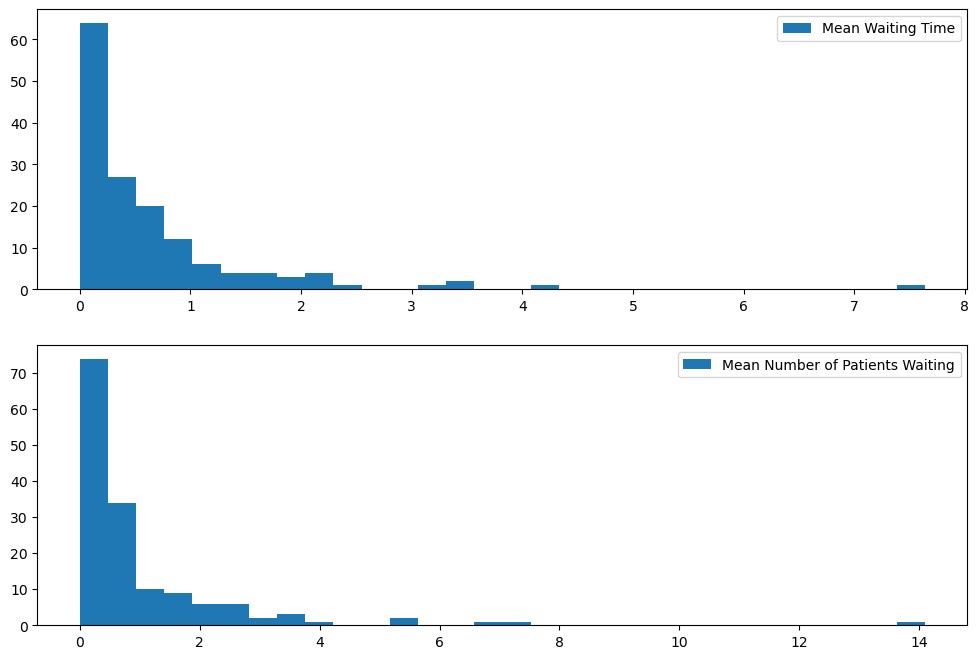

In [12]:
print('Running multiple replications', end=' => ')
results  = multiple_runs(n_runs=150)
print('done.\n')

# Plots histogram of results
fig, ax = plt.subplots(2, 1, figsize=(12,8))
ax[0].hist(results['mean_waiting_time'], bins=30, label='Mean Waiting Time');
ax[1].hist(results['mean_no_patients_waiting'], bins=30,
           label='Mean Number of Patients Waiting');
ax[0].legend()
ax[1].legend()
plt.show()

**Checks**

In [13]:
class TestCase:
    def __init__(self, ward, run_length=60):
        self.ward = ward
        self.env = ward.env
        self.run_length = run_length

    def test_run_length(self):
        '''
        Checks that specified run length is implemented correctly.
        '''
        env_fin = self.ward.run(results_collection_period=self.run_length,
                                check=True)
        print('\n')
        summary = self.ward.summary()
        print(summary)

        if env_fin.now > self.run_length:
            print('\nThe simulation has continued for longer than input.')

    def test_bed_hold(self):
        '''
        Checks that patients are holding beds until they leave the model.
        '''
        self.ward.run(results_collection_period=self.run_length)
        print('\n')
        summary = self.ward.summary()
        print(summary)

        for bed_use in self.ward.bed_in_use_store:
            if bed_use > ward.args.num_beds:
                print('\nThe number of beds in use exceeded limit.')

    def test_length_of_stay_change(self, shortest_stay):
        '''
        Checks how changing the length of stay for different patinet types
        influences the patient discharges. Change the length of stay parameters
        so one patient type has a much shorter length of stay (shortest_stay).
        Checks that only a few of the other patient types are discharged and
        gives their length of stay.
        '''
        self.ward.run(results_collection_period=self.run_length)
        print('\n')
        summary = self.ward.summary()
        print(summary)

        for los, type in zip(self.ward.los_store, self.ward.discharge_store):
            if type != shortest_stay:
                print(f'\nPatient type {type} stayed for {los}.')

    def test_patients(self):
        '''
        Prints out patient type and their length of stay.
        '''
        self.ward.run(results_collection_period=self.run_length)
        print('\n')
        summary = self.ward.summary()
        print(summary)
        
        print('\n')
        for pat in self.ward.patient_store:
            print(f'{pat.id} ({pat.type}): LOS = {pat.length_of_stay}')

In [14]:
TRACE = True

# Checks run length
scenario = Scenario()
ward = StrokeWard(scenario)

test = TestCase(ward, run_length=10)
test.test_run_length()

Patient 0 of type Stroke admitted at day 1.02
Patient 1 of type TIA admitted at day 2.01
Patient 2 of type Complex NL admitted at day 2.33
Patient 3 of type Stroke admitted at day 2.63
Patient 4 of type Stroke admitted at day 2.99
Patient 5 of type Other admitted at day 3.36
Patient 6 of type Stroke admitted at day 3.67
Patient 4 of type Stroke discharged at day 3.84 and goes to Other
Patient 7 of type TIA admitted at day 3.84
Patient 0 of type Stroke discharged at day 4.05 and goes to Other
Patient 1 of type TIA discharged at day 4.08 and goes to Other
Patient 7 of type TIA discharged at day 4.13 and goes to Other
Patient 2 of type Complex NL discharged at day 4.64 and goes to Other
Patient 8 of type Stroke admitted at day 4.8
Patient 9 of type Stroke admitted at day 4.82
Patient 10 of type Other admitted at day 5.0
Patient 10 of type Other discharged at day 5.64 and goes to Other
Patient 11 of type Stroke admitted at day 5.97
Patient 12 of type Stroke admitted at day 6.03
Patient 8 o

In [15]:
# Checks that is only ever 1 patient if there is only 1 bed
NUM_BEDS = 1

scenario = Scenario()
ward = StrokeWard(scenario)

test = TestCase(ward)
test.test_bed_hold()

Patient 0 of type Stroke admitted at day 1.02
Patient 0 of type Stroke discharged at day 4.05 and goes to Other
Patient 1 of type TIA admitted at day 4.05
Patient 1 of type TIA discharged at day 6.12 and goes to Other
Patient 2 of type Complex NL admitted at day 6.12
Patient 2 of type Complex NL discharged at day 8.43 and goes to Other
Patient 3 of type Stroke admitted at day 8.43
Patient 3 of type Stroke discharged at day 18.71 and goes to Other
Patient 4 of type Stroke admitted at day 18.71
Patient 4 of type Stroke discharged at day 19.56 and goes to Other
Patient 5 of type Other admitted at day 19.56
Patient 5 of type Other discharged at day 34.58 and goes to Other
Patient 6 of type Stroke admitted at day 34.58
Patient 6 of type Stroke discharged at day 58.09 and goes to Other
Patient 7 of type TIA admitted at day 58.09
Patient 7 of type TIA discharged at day 58.38 and goes to Other
Patient 8 of type Stroke admitted at day 58.38


   mean_waiting_time  mean_no_patients_waiting
0    

In [16]:
# Checks patient types other than the one with the shortest stay that have
# been discharged, to check this does not fall outside expected range
NUM_BEDS = 10

STROKE_LOS = (60, 5.0)
STROKE_ESD_LOS = (60, 5.0)
STROKE_MORT_LOS = (60, 5.0)
TIA_LOS = (60, 5.0)
CNL_LOS = (60, 5.0)
OTHER_LOS = (1.5, 5.0)

scenario = Scenario()
ward = StrokeWard(scenario)

test = TestCase(ward)
test.test_length_of_stay_change('Other')

Patient 0 of type Stroke admitted at day 1.02
Patient 1 of type TIA admitted at day 2.01
Patient 2 of type Complex NL admitted at day 2.33
Patient 3 of type Stroke admitted at day 2.63
Patient 4 of type Stroke admitted at day 2.99
Patient 5 of type Other admitted at day 3.36
Patient 6 of type Stroke admitted at day 3.67
Patient 7 of type TIA admitted at day 3.84
Patient 8 of type Stroke admitted at day 4.8
Patient 9 of type Stroke admitted at day 4.82
Patient 5 of type Other discharged at day 11.39 and goes to Other
Patient 10 of type Other admitted at day 11.39
Patient 10 of type Other discharged at day 11.45 and goes to Other
Patient 11 of type Stroke admitted at day 11.45
Patient 4 of type Stroke discharged at day 54.12 and goes to Other
Patient 12 of type Stroke admitted at day 54.12
Patient 7 of type TIA discharged at day 57.15 and goes to Other
Patient 13 of type Other admitted at day 57.15
Patient 13 of type Other discharged at day 57.21 and goes to Other
Patient 14 of type Comp

In [17]:
# Prints out patient type and their length of stay
STROKE_LOS = (7.4, 8.6)
STROKE_ESD_LOS = (4.6, 4.8)
STROKE_MORT_LOS = (7.0, 8.7)
TIA_LOS = (1.8, 2.3)
CNL_LOS = (4.0, 5.0)
OTHER_LOS = (3.8, 5.2)

scenario = Scenario()
ward = StrokeWard(scenario)

test = TestCase(ward, run_length=10)
test.test_patients()

Patient 0 of type Stroke admitted at day 1.02
Patient 1 of type TIA admitted at day 2.01
Patient 2 of type Complex NL admitted at day 2.33
Patient 3 of type Stroke admitted at day 2.63
Patient 4 of type Stroke admitted at day 2.99
Patient 5 of type Other admitted at day 3.36
Patient 6 of type Stroke admitted at day 3.67
Patient 4 of type Stroke discharged at day 3.84 and goes to Other
Patient 7 of type TIA admitted at day 3.84
Patient 0 of type Stroke discharged at day 4.05 and goes to Other
Patient 1 of type TIA discharged at day 4.08 and goes to Other
Patient 7 of type TIA discharged at day 4.13 and goes to Other
Patient 2 of type Complex NL discharged at day 4.64 and goes to Other
Patient 8 of type Stroke admitted at day 4.8
Patient 9 of type Stroke admitted at day 4.82
Patient 10 of type Other admitted at day 5.0
Patient 10 of type Other discharged at day 5.64 and goes to Other
Patient 11 of type Stroke admitted at day 5.97
Patient 12 of type Stroke admitted at day 6.03
Patient 8 o

In [19]:
# Testing random seeds
TRACE = False
args = Scenario(random_number_set=[1])
results, ward_admit1, los_store1, route_out1, mort1 = single_run(args,
                                                                 check=True)
print('\n')
print(results)

args = Scenario(random_number_set=[1, 2])
results, ward_admit2, los_store2, route_out2, mort2 = single_run(args,
                                                                 check=True)
print('\n')
print(results)

for arrival1, arrival2 in zip(ward_admit1, ward_admit2):
    if arrival1 != arrival2:
        print('Different arrival times on the ward for the same random seed.')

for los1, los2 in zip(los_store1, los_store2):
    if los1 != los2:
        print('Different patient LOS for the same random seed.')

print('\n')
for out1, out2, mt1, mt2 in zip(route_out1, route_out2, mort1, mort2):
    print(f'Destination 1: {out1}; Destination 2: {out2}'
          f'\nMortality 1: {mt1}, Mortality 2: {mt2}\n')



   mean_waiting_time  mean_no_patients_waiting
0           0.751966                  1.188119


   mean_waiting_time  mean_no_patients_waiting
0           0.751966                  1.188119


Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 1, Mortality 2: 1

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 0, Mortality 2: 0

Destination 1: Other; Destination 2: Other
Mortality 1: 